# Movie Data
You are a Data Scientist for a top movie studio. After a series of box office flops, the producers of your studio are starting to question their strategy and need some direction. You suggest a new approach - using data to determine what factors go into making a successful film. Luckily, you have a dataset of over 5000 films to mine for insights. Your producers ask you to spend some time analyzing the data and present a report detailing your findings, along with recommendations on how to revamp the studio’s strategy. 

In [2]:
import pandas as pd
import numpy as np
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
movies = pd.read_csv('movie_data.csv')
#print(movies.columns)
#print(movies.info())
#movies

## Explore and Clean Dataset

In [4]:
print(movies['title_year'].min())
print(movies['title_year'].max())

1916.0
2016.0


In [5]:
# remove all movies from before the year 1996 in order to focus on the most recent data points
movies['budget_millions'] = round(movies['budget'] / 1000000, 2)
movies['gross_millions'] = round(movies['gross'] / 1000000, 2)
movies['revenue_millions'] = movies['gross_millions'] - movies['budget_millions'] 

movies_f = movies[movies['title_year']>=1996]

movies_gross_filter = movies[movies['gross_millions']>=100]

## Success Metrics
Which of the metrics that we have access to demonstrate the success of a film?

Potential measures of success:
1. num_critic_review
2. gross
3. num_user_reviews
4. movie_score

## Explore Relationships in the Data

In [6]:
#sns.scatterplot(data = movies_gross_filter,x ='movie_score',y='gross_millions')

In [13]:
#sns.scatterplot(data = movies_gross_filter,x ='num_critic_reviews',y='gross_millions')

In [14]:
corr_matrix = movies_f.corr()
corr_matrix.to_csv('corr_matrix.csv')

corr_matrix

,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_users_voted,cast_total_facebook_likes,num_user_reviews,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,budget_millions,gross_millions,revenue_millions
num_critic_reviews,1.000000,0.350882,0.222121,0.266942,0.180542,0.518561,0.680583,0.256126,0.604871,0.114369,0.295811,0.286257,0.386884,0.007760,0.693756,0.114369,0.518561,0.049059
duration,0.350882,1.000000,0.202876,0.162548,0.100870,0.295520,0.394984,0.146985,0.416947,0.093626,-0.034834,0.162105,0.332457,0.051635,0.271754,0.093626,0.295520,0.001252
director_facebook_likes,0.222121,0.202876,1.000000,0.147302,0.084609,0.134902,0.316522,0.122478,0.243813,0.028798,-0.028033,0.135795,0.156780,0.005769,0.188317,0.028798,0.134902,0.013388
actor_3_facebook_likes,0.266942,0.162548,0.147302,1.000000,0.243551,0.327113,0.318123,0.472249,0.232055,0.043370,0.064098,0.567027,0.074906,0.003697,0.276721,0.043370,0.327113,0.056222
actor_1_facebook_likes,0.180542,0.100870,0.084609,0.243551,1.000000,0.159139,0.194256,0.950932,0.138117,0.018629,0.034297,0.381122,0.095414,0.000966,0.128164,0.018629,0.159139,0.029732
gross,0.518561,0.295520,0.134902,0.327113,0.159139,1.000000,0.670155,0.261419,0.590170,0.107478,0.100290,0.289411,0.180033,0.070930,0.394595,0.107478,1.000000,0.186256
num_users_voted,0.680583,0.394984,0.316522,0.318123,0.194256,0.670155,1.000000,0.278105,0.805840,0.088212,-0.000314,0.295567,0.421143,0.009731,0.549874,0.088212,0.670155,0.117539
cast_total_facebook_likes,0.256126,0.146985,0.122478,0.472249,0.950932,0.261419,0.278105,1.000000,0.202568,0.031981,0.051471,0.622283,0.108747,0.002588,0.204129,0.031981,0.261419,0.047252
num_user_reviews,0.604871,0.416947,0.243813,0.232055,0.138117,0.590170,0.805840,0.202568,1.000000,0.084575,-0.118995,0.223122,0.303915,0.001674,0.378664,0.084575,0.590170,0.097577
budget,0.114369,0.093626,0.028798,0.043370,0.018629,0.107478,0.088212,0.031981,0.084575,1.000000,-0.002127,0.041319,0.045407,-0.000697,0.058059,1.000000,0.107478,-0.956792


## Analyze director success

Do certain director's tend to make more successful movies?

In [15]:
#group by director; average gross income
directors_gross = movies_f[['director_name','gross']].groupby(['director_name']).mean().sort_values(by='gross', ascending=False)
directors_gross['gross_millions'] = round(directors_gross['gross'] / 1000000, 2)

#directors_gross.head(10)

In [16]:
#group by director; count number of movies
directors_count = movies_f[['director_name','color']].groupby(['director_name']).count().sort_values(by='color',ascending = False)
directors_count = directors_count.rename(columns = {'color': 'num_movies'})

#directors_count

In [17]:
#group by director; average movie score
directors_score = movies_f[['director_name','movie_score']].groupby(['director_name']).mean().sort_values(by='movie_score', ascending = False)

#directors_score.head(10)

In [18]:
#group by director; average budget
directors_budget = movies_f[['director_name','budget']].groupby(['director_name']).mean().sort_values(by='budget', ascending = False)
directors_budget['budget_millions'] = round(directors_budget['budget'] / 1000000, 2)

#directors_score.head(10)

In [19]:
#group by director; average facebook likes
director_fblikes = movies_f[['director_name','director_facebook_likes']].groupby(['director_name']).mean().sort_values(by='director_facebook_likes', ascending = False)

#director_fblikes.head(10)

In [20]:
#group by director; average movie facebook likes
movie_fblikes = movies_f[['director_name','movie_facebook_likes']].groupby(['director_name']).mean().sort_values(by='movie_facebook_likes', ascending = False)

#movie_fblikes.head(10)

In [25]:
# merge director data into one df
directors_df_lst = [directors_gross, directors_budget, directors_count, directors_score, director_fblikes, movie_fblikes]
directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)
directors_df = directors_df.drop(columns=['gross', 'budget'])
directors_df = directors_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                             'movie_score': 'avg_movie_score',
                                             'director_facebook_likes':'avg_director_fb_likes',
                                             'movie_facebook_likes':'avg_movie_fb_likes'})

directors_df['avg_movie_score'] = round(directors_df['avg_movie_score'],2)
directors_df['avg_movie_fb_likes'] = round(directors_df['avg_movie_fb_likes'],2)
directors_df.to_csv('directors_df.csv')

# filter df to focus on most successful directors
directors_df_filter = directors_df[directors_df['avg_gross_millions']>=100]

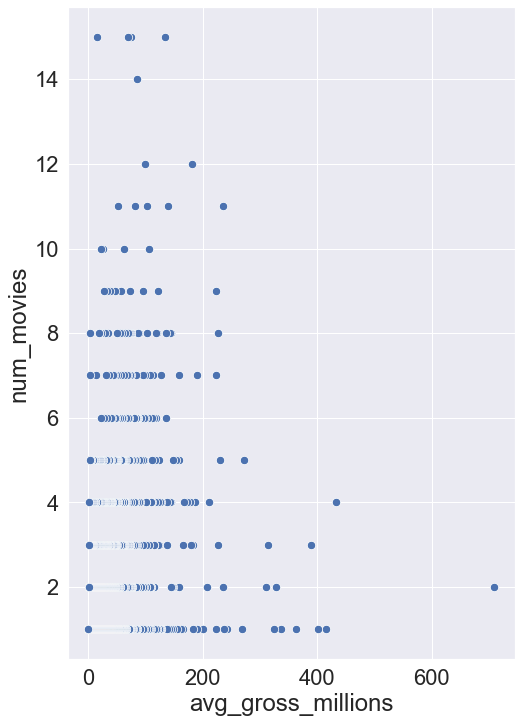

In [41]:
sns.set(rc={'figure.figsize':(8,12)})
sns.set(font_scale=2)
sns.scatterplot(data=directors_df, x="avg_gross_millions", y="num_movies", s = 70)
plt.savefig('director_scatter_nummovies_avggross.png')

In [42]:
# top grossing directors
directors_df_filter.head(10)

,avg_gross_millions,avg_budget_million,num_movies,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes
director_name,,,,,,
James Cameron,709.59,218.50,2,7.80,0.0,29500.00
Joss Whedon,432.72,182.50,4,7.92,0.0,94500.00
Lee Unkrich,414.98,200.00,1,8.30,125.0,30000.00
Chris Buck,400.74,150.00,1,7.60,69.0,58000.00
George Lucas,388.49,114.33,3,6.93,0.0,7666.67
Tim Miller,363.02,58.00,1,8.10,84.0,117000.00
Kyle Balda,336.03,74.00,1,6.40,22.0,70000.00
Colin Trevorrow,328.09,75.38,2,7.00,365.0,90500.00
Yarrow Cheney,323.51,75.00,1,6.80,11.0,36000.00


In [43]:
# directors with top average movie scores
directors_df_filter.sort_values(by = 'avg_movie_score', ascending = False).head(10)

,avg_gross_millions,avg_budget_million,num_movies,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes
director_name,,,,,,
Christopher Nolan,226.65,125.62,8,8.43,22000.0,103625.00
Lee Unkrich,414.98,200.00,1,8.30,125.0,30000.00
Pete Docter,313.11,155.00,3,8.23,0.0,48333.33
Tim Miller,363.02,58.00,1,8.10,84.0,117000.00
Joss Whedon,432.72,182.50,4,7.92,0.0,94500.00
Don Hall,222.49,165.00,1,7.90,38.0,41000.00
James Cameron,709.59,218.50,2,7.80,0.0,29500.00
Rich Moore,189.41,165.00,1,7.80,66.0,40000.00
Alfonso Cuarón,143.09,77.00,4,7.80,0.0,43750.00


In [44]:
# directors who directed the highest number of movies
directors_df_filter.sort_values(by = 'num_movies', ascending = False).head(10)

,avg_gross_millions,avg_budget_million,num_movies,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes
director_name,,,,,,
Steven Spielberg,133.66,88.40,15,7.27,14000.0,19600.00
Michael Bay,180.45,130.67,12,6.63,0.0,21583.33
Ron Howard,101.91,83.82,11,6.94,2000.0,12785.55
Tim Burton,138.33,98.09,11,6.64,13000.0,18272.73
Peter Jackson,235.45,153.36,11,7.70,0.0,35727.27
Brett Ratner,106.20,93.60,10,6.41,420.0,4344.80
M. Night Shyamalan,121.62,72.22,9,6.04,0.0,11333.33
Sam Raimi,223.72,153.56,9,6.71,0.0,15111.11
Robert Zemeckis,101.80,107.62,8,7.01,0.0,17375.00


## Analzye Genre Success

In [154]:
print(range(len(movies['genres'])))

range(0, 5043)


In [155]:
genre_action = movies[movies['genres'].str.contains('Action')]
genre_adventure = movies[movies['genres'].str.contains('Adventure')]
genre_fantasy = movies[movies['genres'].str.contains('Fantasy')]
genre_thriller = movies[movies['genres'].str.contains('Thriller')]
genre_scifi = movies[movies['genres'].str.contains('Sci-Fi')]
genre_crime = movies[movies['genres'].str.contains('Crime')]
genre_comedy = movies[movies['genres'].str.contains('Comedy')]
genre_drama = movies[movies['genres'].str.contains('Drama')]
genre_doc = movies[movies['genres'].str.contains('Documentary')]
genre_romance = movies[movies['genres'].str.contains('Romance')]
genre_horror = movies[movies['genres'].str.contains('Horror')]

genre_lst = ['Action','Adventure','Fantasy','Thriller','Sci-Fi','Crime','Comedy','Drama','Documentary','Romance','Horror']

for x in genre_lst:
    movies['genre_' + x.lower()] = ""

In [156]:
for x in range(len(movies['genres'])):
    for y in genre_lst:
        if y in movies['genres'][x]:
            movies['genre_' + y.lower()][x] = y.lower()
        else:
            movies['genre_' + y.lower()][x] = 'not ' + y.lower()

/Users/kristinkent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kristinkent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Create df to analyzing average outcome by genre

In [169]:
movies_f = movies[movies['title_year']>=1996]

genre_avg = pd.DataFrame()
for x in genre_lst:
    x = movies_f.groupby(['genre_' + x.lower()]).mean()
    x = x.rename_axis('genre', axis= 0)
    genre_avg = genre_avg.append(x)

genre_avg = genre_avg[genre_avg.index.str.contains("not")==False]
genre_avg.to_csv('genre_avg.csv')

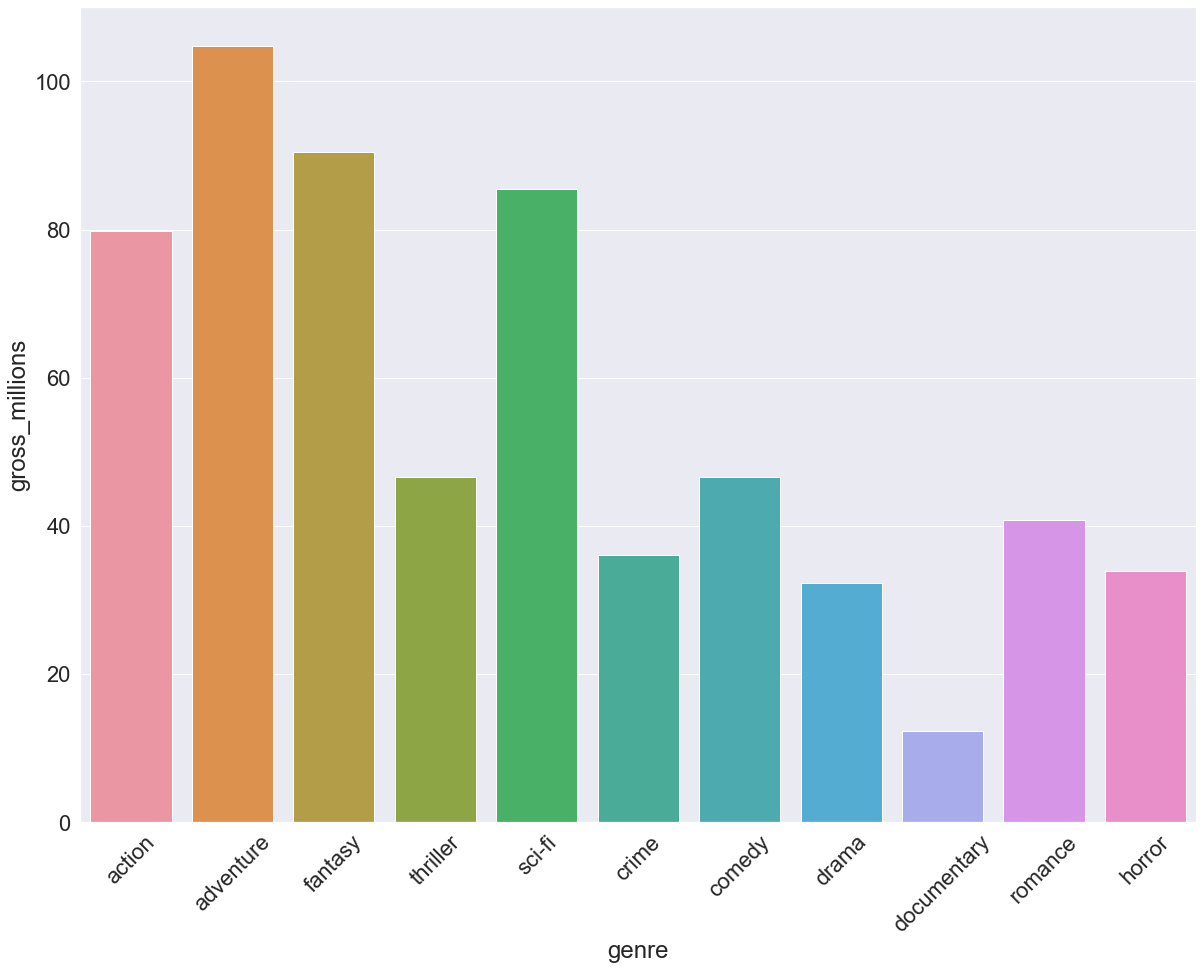

In [160]:
genre_avg_gross = sns.barplot(x= genre_avg.index, y="gross_millions", data=genre_avg)
genre_avg_gross.set_xticklabels(genre_avg_gross.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
plt.savefig('genre_avg_gross.png')

# adventure, action, fantasy, and sci-fi have the highest average gross

In [162]:
#genre_avg_budget = sns.barplot(x= genre_avg.index, y="budget_millions", data=genre_avg)
#genre_avg_budget.set_xticklabels(genre_avg_budget.get_xticklabels(),rotation=45)

# adventure, action, fantasy, and sci-fi have the highest average budget

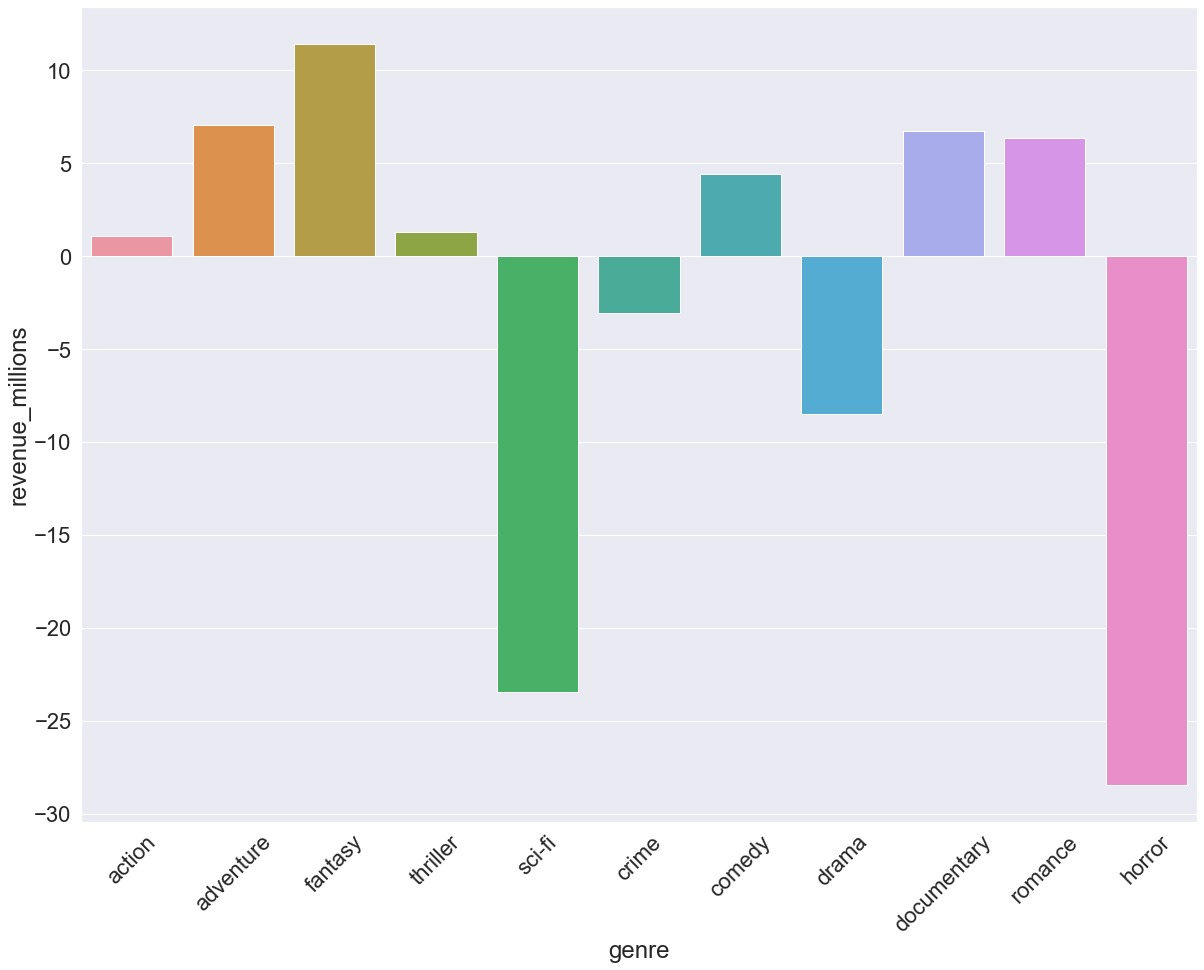

In [163]:
genre_avg_revenue = sns.barplot(x= genre_avg.index, y="revenue_millions", data=genre_avg)
genre_avg_revenue.set_xticklabels(genre_avg_revenue.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
plt.savefig('genre_avg_revenue.png')

# sci-fi and horror movies lose money, on average; fantasy and adventure movies have the highest avg revenue

### Create df to analyzing total outcome (sum) by genre

In [168]:
genre_sum = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).sum()
    x = x.rename_axis('genre', axis= 0)
    genre_sum = genre_sum.append(x)

genre_sum = genre_sum[genre_sum.index.str.contains("not")==False]
#genre_sum.to_csv('genre_sum.csv')

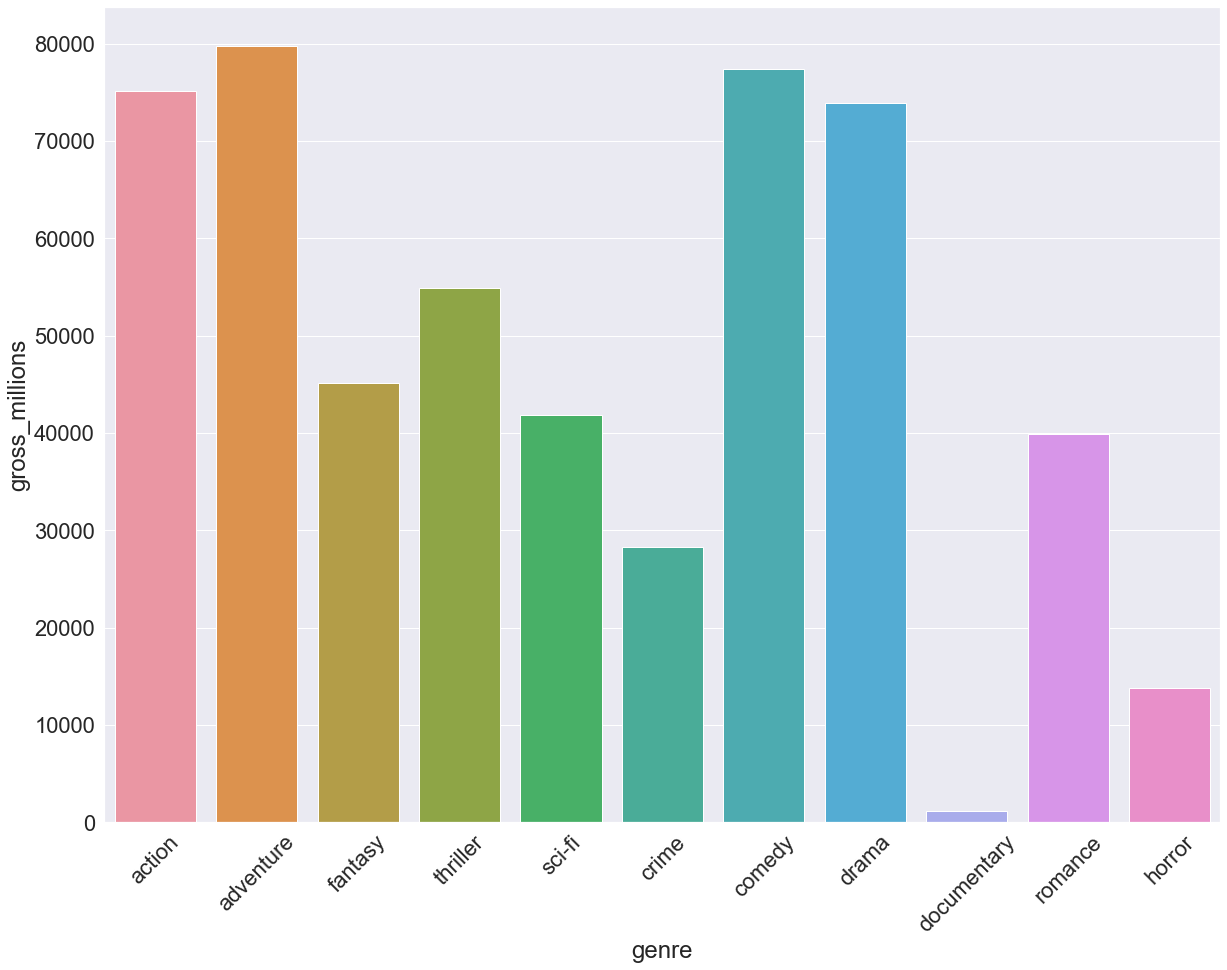

In [164]:
genre_sum_gross = sns.barplot(x= genre_sum.index, y="gross_millions", data=genre_sum)
genre_sum_gross.set_xticklabels(genre_sum_gross.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
plt.savefig('genre_sum_gross.png')

# comedy and drama have high total gross earnings, despite moderate avg. gross earnings

In [ ]:
genre_sum_budget = sns.barplot(x= genre_sum.index, y="budget_millions", data=genre_sum)
genre_sum_budget.set_xticklabels(genre_sum_budget.get_xticklabels(),rotation=45)

AttributeError: 'AxesSubplot' object has no attribute 'to_excel'

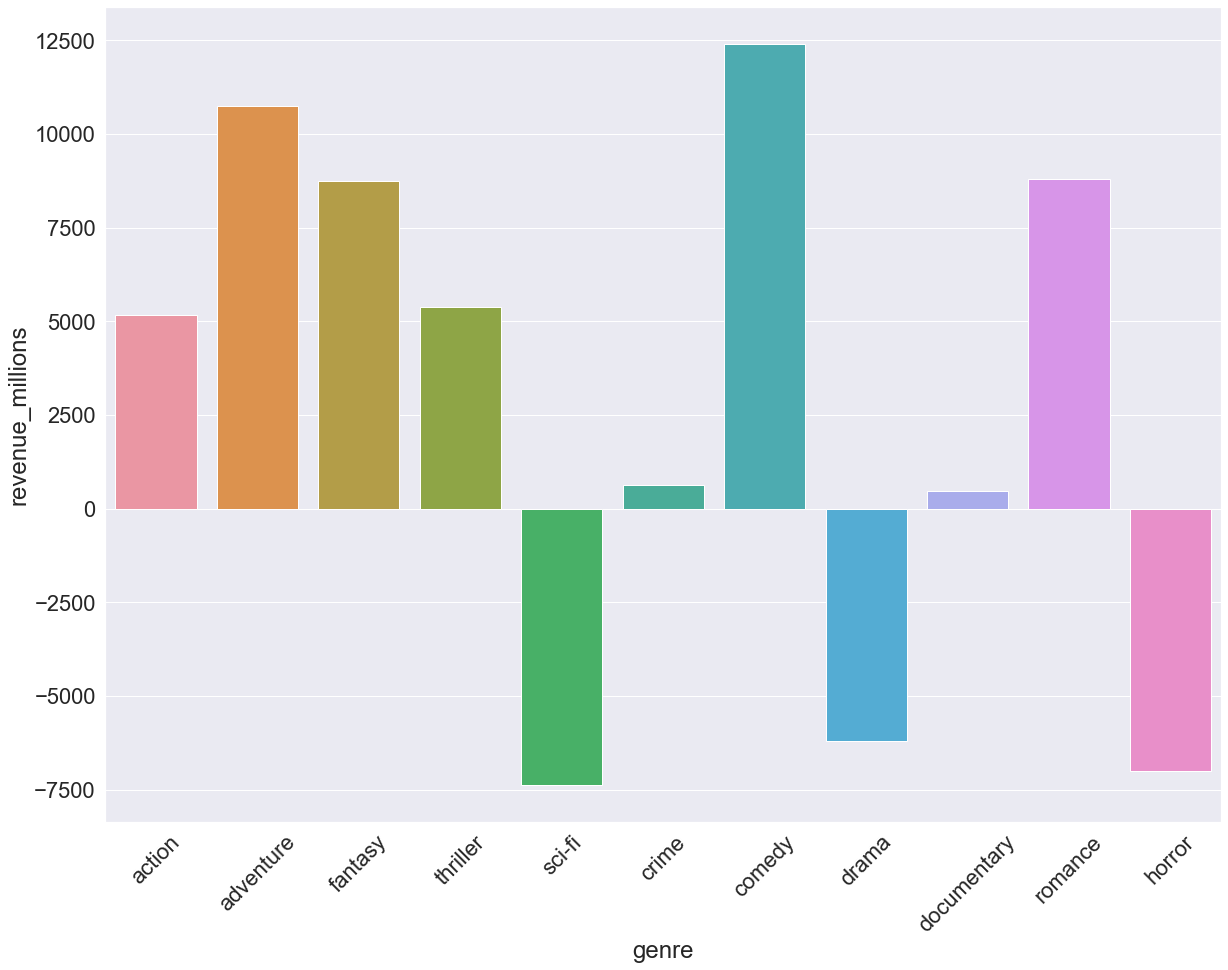

In [166]:
genre_sum_revenue = sns.barplot(x= genre_sum.index, y="revenue_millions", data=genre_sum)
genre_sum_revenue.set_xticklabels(genre_sum_revenue.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
plt.savefig('genre_sum_revenue.png')

# sci-fi, drama, and horror movies lose money overall
# comedy and romance have high total revenue, despite low avg. revenue